### Summary: Implementing Few Shot Learning

**Different Strategies:**

"What I cannot create, I do not understand" - Richard Feynman

- ArcLoss Paper: https://arxiv.org/pdf/1801.07698.pdf
- Blog on Metric Learning: https://index.pocketcluster.io/adambielski-siamese-triplet.html


- 1) Siamese
- 2) Triplet
- 3) ArcLoss
- 4) ...

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

from fastai import *
from fastai.vision import *
from ipyexperiments import *

### Base Loss Functions

In [7]:
# https://www.quora.com/What-is-a-contrastive-loss-function-in-Siamese-networks
class ContrastiveLoss(nn.Module):
    def __init__(self, distfunc, margin):
        """
        dfunc : any distance function
        margin : margin for different class embeddings - min distance
        """
        super().__init__()
        self.distfunc = distfunc
        self.margin = margin
    def forward(self, input, target):
        """
        input: 2 vectors bs x [x1,x2]
        target: bs x [0,1]
        """
        dist = self.distfunc(*input)
        return torch.mean(((1 - target)*(dist)**2 + 
                0.5*(target)*(F.relu(self.margin - dist)**2)), dim=-1)

In [8]:
# choosing cosine dist to set margin easier since it represents an angle
def cosine_dist(x1, x2): return 1 - F.cosine_similarity(x1,x2)

In [81]:
x1 = torch.randn((5,2))
x2 = torch.randn((5,2))
gt = torch.randint(high=2, size=(5,)).float() 
loss = ContrastiveLoss(distfunc=cosine_dist, margin=0.8)

In [82]:
loss((x1, x1), gt)

tensor(0.1920)

In [9]:
# https://www.coursera.org/lecture/convolutional-neural-networks/triplet-loss-HuUtN
class TripletLoss(nn.Module):
    def __init__(self, distfunc, margin):
        """
        dfunc : any distance function
        margin : margin for different class embeddings - min distance
        """
        super().__init__()
        self.distfunc = distfunc
        self.margin = margin
    def forward(self, input):
        """
        input: 3 vectors (anchor, pos, neg) bs x [x1,x2,x3]
        target: bs x [0,1]
        """
        pos_dist = self.distfunc(input[0], input[1])
        neg_dist = self.distfunc(input[0], input[2])
        return torch.mean(F.relu(pos_dist - neg_dist + self.margin), dim=-1)

In [90]:
x1 = torch.randn((5,2)) # anchor
x2 = torch.randn((5,2)) # pos
x3 = torch.randn((5,2)) # neg
loss = TripletLoss(distfunc=cosine_dist, margin=0.4)

In [91]:
loss((x1,x2,x3))

tensor(0.9296)

### Hard Example Mining

- Some inspiration from: https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563
- It constructs hard pairs `at the beginning of each epoch`

#### Matching whale examples
Half the examples used during training are for pair of images. For each whale of the training set, compute a [derangement](https://en.wikipedia.org/wiki/Derangement) of its pictures. Use the original order as picture A, and the derangment as picture B. This creates a random number of matching image pairs, with each image taken exactly two times.

#### Different whales examples
Different whales examples are generated by computing a derangement of all pictures from the training set, subject to:

- The image pairs must belong to different whales;
- The pairs formed must be difficult for the model to distinguish.

The following algorith is used to generate the pairs:

- The similarity between each pair of image is computed using the current model state. This has complexity  n(n−1)2 , where n is the size of the training set. Fortunately, only the head model must be computed for all pairs, and it is very fast. The 512-feature vectors can be pre-computed once for each image, i.e. O(n) complexity.
- Entry that correpond to pair of images from the same whale are set with similarity  −∞ .
- [Linear sum assignment algorithm](https://en.wikipedia.org/wiki/Assignment_problem) is used to find the most difficult matching.
- To randomize the selection, and control the matching difficulty, we add a random matrix to the cost matrix from step #1 . The random matrix has values uniformly distributed between 0 and K. The larger K, the more random the matching. The smaller K, the more difficult the pairing is for the model.
- To produce different matching for successive epochs, the selected entries in the matrix are overwritten with  −∞  to force an alternate selection for the next matching.

In [10]:
class HardExampleMiner:
    def __init__(self):
        """
        1. The number of possible pairs/triplets grows 
        quadratically/cubically with the number of examples.
        It's infeasible to process them all and the training converges slowly.
        
        2. We generate pairs/triplets randomly. As the training continues,
        more and more pairs/triplets are easy to deal with (their loss value
        is very small or even 0), preventing the network from training.
        We need to provide the network with hard examples.
        
        3. Each image that is fed to the network is used only for computation
        of contrastive/triplet loss for only one pair/triplet. The computation 
        is somewhat wasted; once the embedding is computed, it could be reused
        for many pairs/triplets.
        """
        pass
        
    def get_pairs(self, x, target):
        """
        get hard pairs from embeddings x for a loss like ContrastiveLoss
        return (x1, x2, gt)
        """
        pass
        
        
    def get_triplets(self, x, target):
        """
        get hard triplets from embeddings x for a loss like ContrastiveLoss
        return (x1, x2, x3)
        """
        pass

In [11]:
class OnlineContrastiveLoss(nn.Module):
    def __init__(self, distfunc, margin):
        self.loss = ContrastiveLoss(distfunc, margin)
        self.miner = HardExampleMiner()
    
    def forward(self, input, target):
        """
        input: batch of embeddings
        target: class of each image
        """
        x1, x2, gt = self.miner.get_pairs(input, target)
        return self.loss(*(x1, x2, gt), target)

class OnlineTripletLoss(nn.Module):
    def __init__(self, distfunc, margin):
        self.loss = TripletLoss(distfunc, margin)
        self.miner = HardExampleMiner()
    
    def forward(self, input, target):
        """
        input: batch of embeddings
        target: class of each image
        """
        x1, x2, x3 = self.miner.get_triplets(input, target)
        return self.loss(*(x1, x2, x3))

In [104]:
# sample embeddings
x = torch.randn((128, 512))
classes = torch.randint(high=5, size=(128,)).float() # 5 classes

In [100]:
x

tensor([[-0.5800,  0.7002, -0.0628,  ...,  0.5343,  2.0133, -0.2822],
        [ 0.5305, -0.5347,  2.0530,  ...,  0.5491,  0.5270, -1.3611],
        [-0.9309, -0.9566,  0.3007,  ..., -0.1167, -1.1404,  0.6026],
        ...,
        [-2.1967, -0.0480,  0.0456,  ...,  0.9032,  0.9429,  0.7735],
        [-0.2778,  1.6275, -0.0278,  ...,  0.0873,  0.3107, -0.2121],
        [ 0.8474, -2.8168,  1.1796,  ...,  1.6893, -1.5805,  0.7956]])

In [105]:
# a batch of 128 unique images
classes

tensor([0., 1., 0., 4., 1., 4., 3., 1., 2., 3., 0., 2., 0., 4., 3., 2., 3., 4.,
        4., 2., 0., 2., 1., 2., 3., 1., 2., 0., 4., 4., 2., 3., 0., 1., 1., 0.,
        1., 1., 4., 3., 0., 1., 1., 3., 2., 0., 1., 4., 1., 0., 2., 2., 1., 2.,
        4., 4., 1., 1., 1., 1., 2., 1., 3., 2., 2., 0., 2., 2., 1., 3., 3., 3.,
        2., 0., 2., 3., 2., 0., 1., 1., 1., 1., 1., 3., 0., 4., 0., 4., 0., 1.,
        0., 1., 2., 2., 2., 2., 2., 0., 1., 0., 4., 0., 4., 0., 4., 0., 4., 4.,
        0., 0., 1., 2., 3., 0., 3., 0., 1., 3., 4., 1., 4., 1., 4., 0., 3., 4.,
        4., 2.])

In [109]:
# all pairs and triplets
npairs, ntriplets = int(128*127/2), int(128*127*126/6)

In [114]:
constloss = ContrastiveLoss(distfunc=cosine_dist, margin=0.8)

In [121]:
x1 = torch.randn((npairs, 512))
x2 = torch.randn((npairs, 512))
gt = torch.randint(size=(npairs,), high=2).float()

In [122]:
x1.shape, x2.shape, gt.shape

(torch.Size([8128, 512]), torch.Size([8128, 512]), torch.Size([8128]))

In [124]:
%%time
constloss((x1, x2), gt)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.1 ms


tensor(0.4852)

In [127]:
tripletloss = TripletLoss(distfunc=cosine_dist, margin=0.3)

In [125]:
x1 = torch.randn((ntriplets, 512))
x2 = torch.randn((ntriplets, 512))
x3 = torch.randn((ntriplets,512))

In [126]:
x1.shape, x2.shape, x3.shape

(torch.Size([341376, 512]),
 torch.Size([341376, 512]),
 torch.Size([341376, 512]))

In [130]:
%%time
tripletloss((x1,x2,x3))

CPU times: user 1.23 s, sys: 304 ms, total: 1.53 s
Wall time: 1.93 s


tensor(0.3001)

In [1]:
20000*19999

399980000

### begin

In [12]:
data_path = Path('../data/whale/')

In [13]:
sorted(data_path.ls())

[PosixPath('../data/whale/cropped_test'),
 PosixPath('../data/whale/cropped_training'),
 PosixPath('../data/whale/models'),
 PosixPath('../data/whale/submissions'),
 PosixPath('../data/whale/test'),
 PosixPath('../data/whale/test_csv_2.csv'),
 PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/train_csv_2.csv')]

In [14]:
train = pd.read_csv(data_path/'train.csv')

In [15]:
train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [16]:
# whale id image counts - number of whale ids with only single image
w_counts = train.groupby(['Id'])['Id'].count().sort_values(ascending=False)
print(f"number of whale ids with single image: {sum(w_counts == 1)}")
print(f"number of unique whale ids in training: {len(w_counts)}")
w2counts = dict(w_counts)
counts2w = {w2counts[k]:k for k in w2counts}
w2fnames = dict(train.groupby(['Id'])['Image'].apply(lambda x: list(x)))

number of whale ids with single image: 2073
number of unique whale ids in training: 5005


In [17]:
list(w2fnames.items())[-5:]

[('w_ff94900', ['5ac086036.jpg']),
 ('w_ffa542b', ['4f9e431aa.jpg', '8abea550e.jpg', 'cd3a073a2.jpg']),
 ('w_ffa6d42', ['9dd320bb3.jpg']),
 ('w_ffcf5fe', ['d3967e1df.jpg']),
 ('w_ffe8693', ['df4bbd82a.jpg'])]

# Databunch



In [18]:
# classes
idx2w = dict(enumerate(w2counts.keys()))
w2idx = {idx2w[k]:k for k in idx2w}
classes = list(w2counts.keys())

In [19]:
classes[:3], len(classes)

(['new_whale', 'w_23a388d', 'w_9b5109b'], 5005)

In [20]:
# Validation fnames
np.random.seed(42)
train_fnames = []
valid_fnames = []
val_ratio = 0.1
for _, fnames in w2fnames.items():
    if len(fnames) == 1:
        train_fnames += fnames
    else:
        n = len(fnames)
        n_val = max(1, int(n*val_ratio)) 
        fnames = np.random.permutation(fnames)
        train_fnames += list(fnames[n_val:])
        valid_fnames += list(fnames[:n_val])

len(train_fnames), len(valid_fnames)

train_df = train[train.Image.isin(train_fnames)].reset_index(drop=True)
valid_df = train[train.Image.isin(valid_fnames)].reset_index(drop=True)

print(f"unique classes in train : {train_df['Id'].nunique()}")
print(f"unique classes in valid: {valid_df['Id'].nunique()}")
print(f"unique classes with single image: {train_df['Id'].nunique() - valid_df['Id'].nunique()}")

unique classes in train : 5005
unique classes in valid: 2932
unique classes with single image: 2073


In [91]:
def get_data(train_df,
             valid_fnames,
             bs=64,
             size=(112,224),
             train_folder='cropped_training',
             test_folder='cropped_test',
             stats=imagenet_stats):
    """
    cosntruct from dataframe [Image, Id] and validation fnames from Image col
    """
    itemlist = ImageItemList.from_df(train_df, data_path, folder=train_folder,
                                     cols=['Image'])
    itemlists = itemlist.split_by_valid_func(lambda item: True if
                                             Path(item).name in valid_fnames else False)
    labellists = itemlists.label_from_df()
    labellists = labellists.add_test(ImageItemList.from_folder(data_path/test_folder))
    data = (labellists.transform(get_transforms(do_flip=False,
                                                max_zoom=1.1,
                                                max_warp=0),
                                 size=size,
                                 resize_method=ResizeMethod.SQUISH, 
                                 # ResizeMethod.SQUISH forces (112, 224) to (128,224)
                                 padding_mode='border')
                      .databunch(bs=bs)
                      .normalize(stats))
    return data

In [92]:
train.head(2)

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a


In [93]:
data = get_data(train, valid_fnames=valid_fnames, size=(224,448))

torch.Size([3, 224, 448])


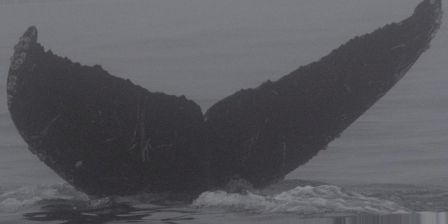

In [171]:
i = np.random.choice(range(len(data.test_ds)))
print(data.train_ds[i][0].data.size()); data.train_ds[i][0]

In [186]:
list(w2counts.items())[-10:]

[('w_b7ec7f8', 1),
 ('w_55fffeb', 1),
 ('w_55782b0', 1),
 ('w_55ef07b', 1),
 ('w_55ed30b', 1),
 ('w_55e0064', 1),
 ('w_b82d0eb', 1),
 ('w_5591cd8', 1),
 ('w_b860053', 1),
 ('w_ffe8693', 1)]

In [214]:
train = train.reset_index()[['Image', 'Id', 'index']]

In [218]:
w2idx = dict(train.groupby('Id').apply(lambda x: list(x['index'])))

In [219]:
list(w2idx.items())[-10:]

[('w_ff3efba', [17746]),
 ('w_ff5fc91', [7031, 21237]),
 ('w_ff6065f', [6865]),
 ('w_ff65f67', [14668]),
 ('w_ff7a4ae', [9884]),
 ('w_ff94900', [8926]),
 ('w_ffa542b', [7899, 13772, 20368]),
 ('w_ffa6d42', [15665]),
 ('w_ffcf5fe', [21003]),
 ('w_ffe8693', [22207])]

# Training

In [95]:
from utils import map5
from fastai.callbacks import EarlyStoppingCallback, TerminateOnNaNCallback, ReduceLROnPlateauCallback
from fastai.train import BnFreeze

In [96]:
# validation baseline accuracy
np.mean(train[train['Image'].isin(valid_fnames)]['Id'] == 'new_whale')

0.2401193139448173

In [97]:
# define calllbacks
early_stopping = partial(EarlyStoppingCallback, monitor="map5", mode="max", patience=10)
terminate_nan = TerminateOnNaNCallback()
reduce_lr = partial(ReduceLROnPlateauCallback, monitor="map5", mode='max',
                    patience=5, factor=0.7)

### Baseline Siamese

**Steps**

- At beginning of a epoch generate good pairs to train for a while:
    - Compute embeddings of each image
    - Select matching pairs
    - Select unmatching pairs
    - Create data from equal matching-unmatching pairs

In [189]:
train_known = train[train.Id != 'new_whale']

In [190]:
train_known.shape

(15697, 2)

In [191]:
# embedding extractor model
cnn_body = nn.Sequential(*[create_body(arch=models.resnet50, pretrained=True),
                           AdaptiveConcatPool2d(),
                           Flatten()])

In [193]:
data = get_data(train_known.sample(1000), valid_fnames=[], size=(224,448))

In [201]:
learner = Learner(data=data, model=cnn_body)

In [ ]:
learner.get_preds()

In [198]:
data.train_ds.items

array(['../data/whale/cropped_training/9d456a88d.jpg', '../data/whale/cropped_training/e5aa8cc13.jpg',
       '../data/whale/cropped_training/27f8d73bc.jpg', '../data/whale/cropped_training/4b93d466a.jpg', ...,
       '../data/whale/cropped_training/12d78ba10.jpg', '../data/whale/cropped_training/d6cd256bf.jpg',
       '../data/whale/cropped_training/f7af1b985.jpg', '../data/whale/cropped_training/e24dc24b8.jpg'], dtype='<U45')

In [194]:
bx, by = data.one_batch()

In [196]:
bx.shape, by.shape

(torch.Size([64, 3, 224, 448]), torch.Size([64]))

In [182]:
embeddings = cnn_body(bx)

In [183]:
embeddings.shape

torch.Size([64, 4096])

In [184]:
by

tensor([ 626, 3131,  750, 1609, 2934, 3658,    0,    0,    0, 4770,    0, 2135,
           0,    0, 4812, 1026, 3029, 3353,    0,    0,    0,    0, 2807,    0,
        1106, 3857, 4964, 2538,    0,    0,    0,    0,    0,    0, 4585,  624,
        2641,    0,    0,    0,    0, 4557, 2508, 2342,    0, 3488, 1874,    0,
           0, 4935,   86,    0,    0, 1000,    0,    0,    0,  386,    0, 4956,
        3731,    0,    0, 2558])

In [222]:
list(w2idx.items())[-10:]

[('w_ff3efba', [17746]),
 ('w_ff5fc91', [7031, 21237]),
 ('w_ff6065f', [6865]),
 ('w_ff65f67', [14668]),
 ('w_ff7a4ae', [9884]),
 ('w_ff94900', [8926]),
 ('w_ffa542b', [7899, 13772, 20368]),
 ('w_ffa6d42', [15665]),
 ('w_ffcf5fe', [21003]),
 ('w_ffe8693', [22207])]

In [287]:
# get matching
# filter desired whales and n images > 1
# generates idxs of original train dataframe
unique_ws = train_known['Id'].unique()
w2idx_match = {w:w2idx[w] for w in w2idx if (w in unique_ws) and (len(w2idx[w]) > 1)}

len(w2idx_match)

n_matching = 0
for l in list(w2idx_match.values()): n_matching += len(l) 

print("number of random matching pairs that will be created", n_matching)

matching_A = []
matching_B = []
for k in w2idx_match:
    idxs, dearanged_idxs = np.array(w2idx_match[k]), np.random.permutation(w2idx_match[k])
    while np.any(idxs == dearanged_idxs):
        # shuffle until a dearangment is created
        dearanged_idxs = np.random.permutation(w2idx_match[k])
    
    matching_A += list(idxs)
    matching_B += list(dearanged_idxs)

print(len(matching_A), len(matching_B))

# check all are different images
assert np.all(np.array(matching_A) != np.array(matching_B))

number of random matching pairs that will be created 13624
13624 13624


In [295]:
# fnames2idx
fnames2idx = dict(zip(train['Image'], train['index']))

In [297]:
list(fnames2idx.items())[:5]

[('0000e88ab.jpg', 0),
 ('0001f9222.jpg', 1),
 ('00029d126.jpg', 2),
 ('00050a15a.jpg', 3),
 ('0005c1ef8.jpg', 4)]

In [299]:
data.train_ds.x.items

array(['../data/whale/cropped_training/9d456a88d.jpg', '../data/whale/cropped_training/e5aa8cc13.jpg',
       '../data/whale/cropped_training/27f8d73bc.jpg', '../data/whale/cropped_training/4b93d466a.jpg', ...,
       '../data/whale/cropped_training/12d78ba10.jpg', '../data/whale/cropped_training/d6cd256bf.jpg',
       '../data/whale/cropped_training/f7af1b985.jpg', '../data/whale/cropped_training/e24dc24b8.jpg'], dtype='<U45')

In [695]:
# can include new whales as well for non-matching hard sample candidates
data = get_data(train, valid_fnames=valid_fnames, size=(224,448))

In [704]:
# monkey patch training dataloader to allow batch_sampler - sequential sampler
# to match batch sequences to data.train_ds.x.items
# use this data as generator for embeddings
data.train_dl = DeviceDataLoader(DataLoader(data.train_dl.dl.dataset,
                                            batch_size=256,
                                            sampler=torch.utils.data.sampler.SequentialSampler(data.train_ds)
                                           ),
                                            data.train_dl.device, data.train_dl.tfms,
                                            data.train_dl.collate_fn)

In [705]:
learner = Learner(data, cnn_body)

In [706]:
learner.data.train_ds.x.items[:2]

array(['../data/whale/cropped_training/0000e88ab.jpg', '../data/whale/cropped_training/0001f9222.jpg'], dtype='<U45')

In [707]:
learner.data.batch_size

256

In [708]:
# compute embeddings for non-matching pair assignment ~ 10 mins
embeddings, _ = learner.get_preds(ds_type=DatasetType.Train)

In [709]:
embeddings.shape

torch.Size([21338, 4096])

In [710]:
# train dataframe idxs and classes
df_idxs = [fnames2idx[Path(o).name] for o in learner.data.train_ds.x.items]
classes = learner.data.train_ds.y.items

In [712]:
len(df_idxs), len(classes)

(21338, 21338)

In [713]:
# create pairwise cost matrix - by using a cost func
# input to cost func will be 2 embeddings
# we want cost function to return the "hardness" of pairs
# the greater the value the easier the samples to distinguish as different classes
# since linear assignment will minimize the cost matrix
# we will set same whale pairs to very large to not pick same whales as non-matching pairs
# this cost func will run for n**2 - O(N**2)
def cost_func(x1, x2):
    loss = ContrastiveLoss(cosine_dist, margin=0.3) # using loss here for simplicity, can be cnn_head as well
#     loss = ContrastiveLoss(cosine_dist, margin=0.3, add reduce = None, sum, mean) # using loss here for simplicity, can be cnn_head as well
    return loss((x1, x2), target=torch.zeros_like(x1[:, 0]))

In [714]:
embeddings

tensor([[1.2642e-06, 2.5351e-04, 7.3063e-06,  ..., 1.2676e-06, 1.2597e-06,
         1.6886e-06],
        [6.8676e-06, 2.1565e-05, 9.7321e-06,  ..., 6.7836e-06, 7.6261e-06,
         6.7828e-06],
        [1.8433e-06, 2.6421e-05, 2.4375e-06,  ..., 1.0813e-06, 1.2029e-06,
         1.0097e-06],
        ...,
        [3.8078e-06, 7.3633e-05, 8.1368e-06,  ..., 2.8175e-06, 2.6788e-06,
         2.8281e-06],
        [6.3462e-07, 1.0118e-06, 5.8404e-07,  ..., 1.2611e-07, 1.1345e-07,
         1.3947e-07],
        [2.0458e-06, 3.0479e-05, 4.3377e-06,  ..., 1.5221e-06, 1.3873e-06,
         1.4345e-06]])

In [ ]:
def create_cost_matrix(embeddings):
    """
    custom cost matrix generation from embeddings
    indexes should be sequential
    
    - use batching and multithraeding for speed
    """
    
    # do something and create cost matrix
    # e.g. cnn_head() -> 
    # e.g. cosine_dist() - > 
    # e.g. eucledian_dist() - > 
    
    return cost_matrix

In [715]:
matrix_idxs2df_idxs = dict(enumerate((df_idxs)))
df_idxs2matrix_idxs = {matrix_idxs2df_idxs[mat_idx]:mat_idx for mat_idx in matrix_idxs2df_idxs}

In [716]:
list(df_idxs2matrix_idxs.items())[:5]

[(0, 0), (1, 1), (2, 2), (4, 3), (5, 4)]

In [717]:
class PairEmbeddingDataset(Dataset):
    def __init__(self, embeddings, pair_idxs):
        self.embeddings = embeddings
        self.pair_idxs = list(pair_idxs)
    
    def __getitem__(self, index):
        idx1, idx2 = self.pair_idxs[index]
        return self.embeddings[idx1], self.embeddings[idx2]
        
    def __len__(self):
        return len(self.pair_idxs)

In [737]:
# all pairs generator
from itertools import combinations
from tqdm import tqdm_notebook

def create_cost_matrix(embeddings, learner):
    """
    custom cost matrix generation from training embeddings
    indexes should be sequential
    
    - use batching and multithraeding for speed
    """
    # define cost function to calculate f(x1, x2)
    cost_func = F.cosine_similarity
    
    # create an empty cost matrix
    n = len(embeddings)
    cost_matrix = np.zeros((n, n))    
    pair_idxs = list(combinations(range(n), 2))
    
    # create pair dataset and dataloader for fast cost calculation
    pair_ds = PairEmbeddingDataset(embeddings, pair_idxs)
    pair_dl = DataLoader(pair_ds, batch_size=int(2**13), shuffle=False, num_workers=8)
    
    # get costs for each pair and update cost matrix
    cost = []
    for x1, x2 in tqdm_notebook(pair_dl):
        x1, x2 = x1.cuda(), x2.cuda()
        cost += [cost_func(x1, x2)]
    cost = torch.cat(cost)
    cost = cost.cpu().numpy()
    i,j = list(zip(*pair_idxs))
    cost_matrix[i, j] = cost
    
    # set large values to same class pairs
    classes = learner.data.train_ds.y.items
    same_class_pairs = np.array(pair_idxs)[np.where(classes[np.array(i)] == classes[np.array(j)])[0]]
    i, j = list(zip(*same_class_pairs))
    cost_matrix[i, j] = 1e10
    cost_matrix += cost_matrix.T
    cost_matrix[np.diag_indices_from(cost_matrix)] = 1e10
    return cost_matrix

In [738]:
%%time
cost_matrix = create_cost_matrix(embeddings, learner)

MemoryError: 

In [688]:
cost_matrix

array([[1.000000e+10, 8.692394e-03, 5.436172e-02, 5.902066e-03, ..., 1.280329e-02, 8.666025e-01, 2.990504e-01,
        6.696501e-03],
       [8.692394e-03, 1.000000e+10, 2.813417e-02, 5.601639e-03, ..., 3.239571e-01, 1.598770e-01, 6.318404e-01,
        9.665704e-01],
       [5.436172e-02, 2.813417e-02, 1.000000e+10, 7.194378e-02, ..., 1.572504e-01, 1.568190e-01, 9.904390e-02,
        5.575148e-02],
       [5.902066e-03, 5.601639e-03, 7.194378e-02, 1.000000e+10, ..., 3.457025e-02, 6.845301e-03, 8.962051e-03,
        2.772144e-02],
       ...,
       [1.280329e-02, 3.239571e-01, 1.572504e-01, 3.457025e-02, ..., 1.000000e+10, 4.675109e-01, 2.352360e-01,
        3.504084e-01],
       [8.666025e-01, 1.598770e-01, 1.568190e-01, 6.845301e-03, ..., 4.675109e-01, 1.000000e+10, 4.082921e-01,
        1.723878e-01],
       [2.990504e-01, 6.318404e-01, 9.904390e-02, 8.962051e-03, ..., 2.352360e-01, 4.082921e-01, 1.000000e+10,
        7.398231e-01],
       [6.696501e-03, 9.665704e-01, 5.575148e-02, 

In [689]:
from lapjv import lapjv

def non_match_assignments(cost_matrix, solver=lapjv):
    """returns matrix idxs of linear sum assignment"""
    row_assignment, _, _ = lapjv(cost_matrix)
    row_ind, col_ind = np.array(range(len(row_assignment))), row_assignment
    return row_ind, col_ind

In [692]:
%%time
row_ind, col_ind  = non_match_assignments(cost_matrix)

CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 1.05 s


In [693]:
sum(cost_matrix[row_ind, col_ind])

9.508276450636913

In [510]:
# get idxs in train dataframe
non_matching_A = [matrix_idxs2df_idxs[idx] for idx in row_ind]
non_matching_B = [matrix_idxs2df_idxs[idx] for idx in col_ind]

In [524]:
# finally create pairs training dataframe
pairs_df = pd.concat([pd.DataFrame({"Image_A": train.iloc[matching_A]['Image'].values,
 "Image_B": train.iloc[matching_B]['Image'].values,
"Is_Matching": 1}),
pd.DataFrame({"Image_A": train.iloc[non_matching_A]['Image'].values,
 "Image_B": train.iloc[non_matching_B]['Image'].values,
"Is_Matching": 0})])

In [526]:
pairs_df.head()

,Image_A,Image_B,Is_Matching
0,2f31725c6.jpg,cc6c1a235.jpg,1
1,30eac8c9f.jpg,47bd1d3bb.jpg,1
2,3c4235ad2.jpg,30eac8c9f.jpg,1
3,47bd1d3bb.jpg,ee87a2369.jpg,1
4,5934e01ea.jpg,3c4235ad2.jpg,1
